In [2]:
import numpy as np
import pandas as pd
from functions import *
from schemes import *
from plot import * 
from Kepler import *
from adaptive import *

%matplotlib inline

In [3]:
def solver(T, C, hlim, r0s, v0s, G, masses, h0 = 0.01, t0 = 0):
    
    # reposition centre of mass to origin with no momentum 
    rcom, vcom = CentreOfMass(r0s, v0s, masses)
    r0s -= rcom
    v0s -= vcom
    
    # Make a copy of initial values
    rs = np.copy(r0s)
    vs = np.copy(v0s)
    t = t0
    h = h0
    
    # Initialize our saved trajectories to be blank 
    t_vals = [t0]
    rs_traj = [r0s] 
    vs_traj = [v0s] 
    E_traj = [TotalEnergy(r0s, v0s, G, masses)]
    am_traj = [AngMomentum(r0s, v0s, masses)]
    # ke_traj = [KineticEnergy(v0s, masses)]
    # pe_traj = [PotentialEnergy(r0s, G, masses)]
    times = 0 
    
    E0 = np.sum(E_traj[0])
    E0hat = E0 
    
    ## conditions to avoid dividing by zero 
    if E0hat == 0: E0hat = np.max(np.abs(E_traj[0])) 
    if E0hat == 0: E0hat = 1

    def maxDist(rs):
        d = -1
        n = len(rs)
        for i in range(0,n-1): 
            for j in range(i, n):
                d = max(d, np.linalg.norm(rs[i]-rs[j]))
        return d

    rs, vs = PEFRLStep(rs, vs, h, G, masses) 
    
    # run scheme for requried number of steps 
    while t <= T:
        t1 = time.time()

        h = C * findh(rs, vs) # proposed timestep

        rs_bar, vs_bar = PEFRLStep(rs, vs, h, G, masses)
        h_bar = C * findh(rs_bar, vs_bar) # proposed timestep

        h_new = (h + h_bar) / 2
        
        rs, vs = PEFRLStep(rs, vs, h_new, G, masses)

        times += time.time() - t1

        E = TotalEnergy(rs, vs, G, masses) # Calculate Energy 
        am = AngMomentum(rs, vs, masses) # Calculate angular momentum 
        # ke = KineticEnergy(vs, masses)
        # pe = PotentialEnergy(rs, G, masses)
        
        if h_new < hlim: 
            print('End due to stepsize')
            break
        if t+h_new > T: 
            print('Time-limit reached')
            break 
        if np.abs(np.sum(E) - E0) / np.abs(E0hat) > 0.01:
            print('Energy Error High')
            break 
        if maxDist(rs) > 10:
            print('Particles too far apart')
            break 
        
        t += h_new

        ## append values to trajectories 
        t_vals = t_vals + [t]
        rs_traj = rs_traj + [rs] 
        vs_traj = vs_traj + [vs]
        E_traj = E_traj + [E]
        # ke_traj = ke_traj + [ke]
        # pe_traj = pe_traj + [pe]
        am_traj = am_traj + [am]
        
    # Make trajectories into numpy arrays
    rs_traj = np.array(rs_traj)
    vs_traj = np.array(vs_traj) 
    E_traj = np.array(E_traj)
    am_traj = np.array(am_traj)
    
    # reposition centre of mass to origin with no momentum 
    rs_traj = np.array([rs + rcom for rs in rs_traj])
    vs_traj = np.array([vs + vcom for vs in vs_traj])
    
    return (t_vals, rs_traj, vs_traj, E_traj, am_traj, times)# , ke_traj, pe_traj

#### FIG 8

In [22]:
# gravity
G = 1

m1 = 1 
m2 = 1 
m3 = 1

# position
r1 = np.array([0,0.0,0.0], dtype="float64")
r2 = np.array([1,0.0,0.0], dtype="float64")
r3 = np.array([-1,0.0,0.0], dtype="float64")

p1 = 0.347111
p2 = 0.532728

# velocity 
v1 = np.array([-2 * p1,-2*p2,0], dtype="float64")
v2 = np.array([p1,p2,0], dtype="float64")
v3 = np.array([p1,p2,0], dtype="float64")

# create initial vectors
r0s = np.array([r1,r2,r3])
v0s = np.array([v1,v2,v3])
masses = np.array([m1, m2, m3])

In [34]:
T = 1000
hlim = 1e-3
C = 0.55

In [35]:
traj = solver(T, C, hlim, r0s, v0s, G, masses)

Time-limit reached


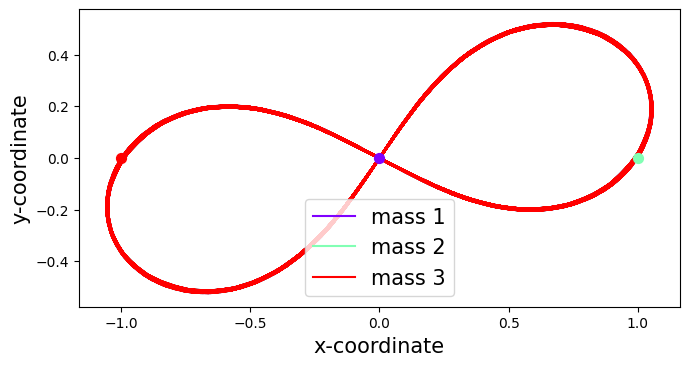

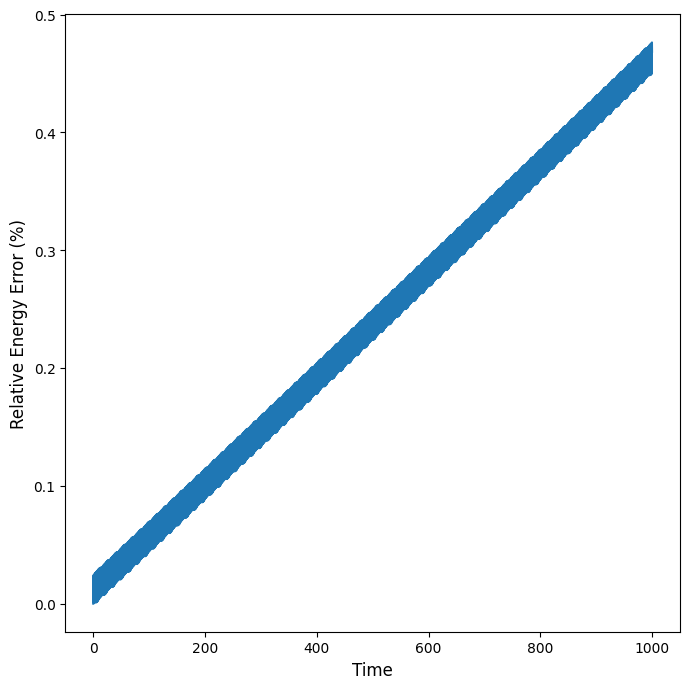

In [36]:
PlotOrbits(traj)
PlotEnergy(traj)

In [37]:
hvals = np.diff(traj[0])

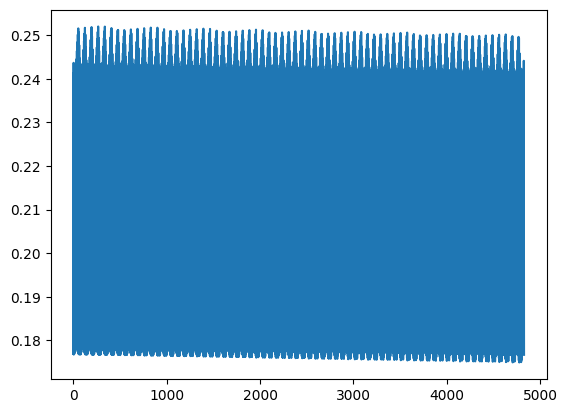

In [38]:
plt.plot(hvals)

#### EULER

In [9]:
# gravity
G = 1

m1 = 1
m2 = 1
m3 = 1

# position
r1 = np.array([-1,0.0,0.0], dtype="float64")
r2 = np.array([0,0.0,0.0], dtype="float64")
r3 = np.array([1,0.0,0.0], dtype="float64")
 
w = np.sqrt(1.25)
# velocity 
v1 = w* np.array([0,-1,0], dtype="float64")
v2 = w* np.array([0,0,0], dtype="float64")
v3 = w* np.array([0,1,0], dtype="float64")

# create initial vectors
r0s = np.array([r1,r2,r3])
v0s = np.array([v1,v2,v3])
masses = np.array([m1, m2, m3])

In [10]:
traj = solver(100, 0.25, hlim, r0s, v0s, G, masses)

Time-limit reached


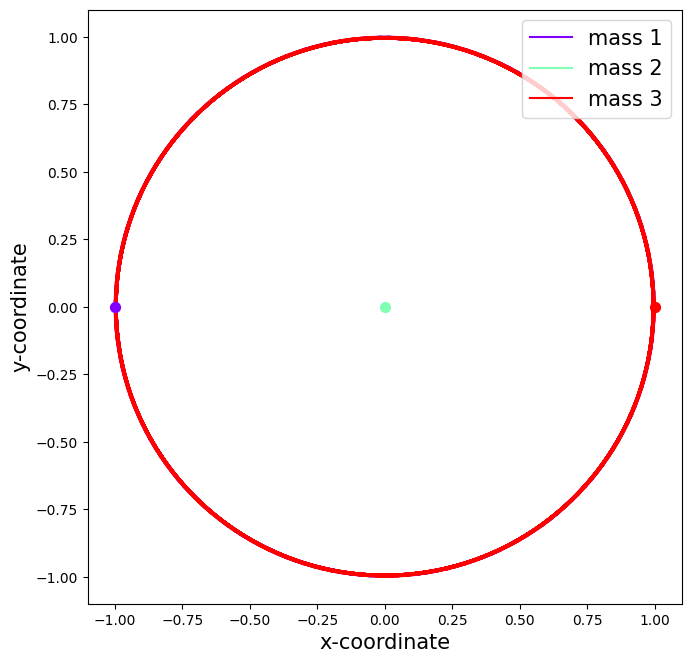

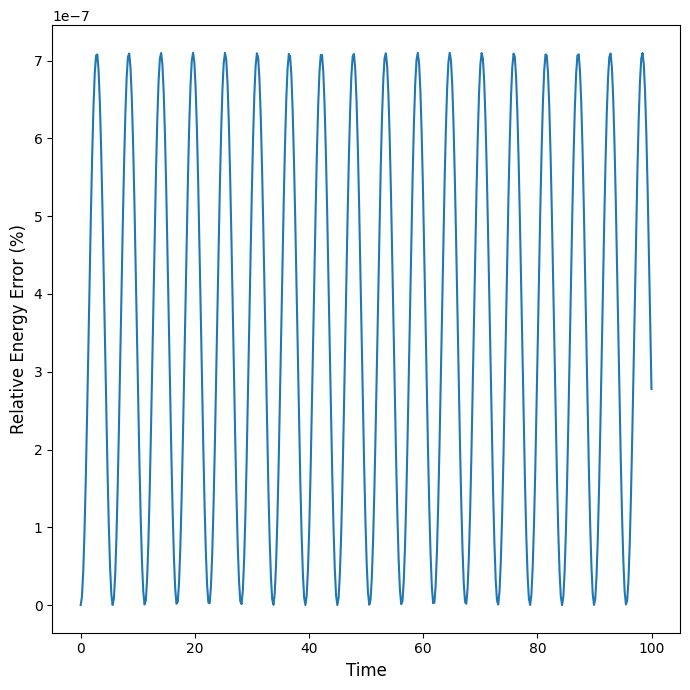

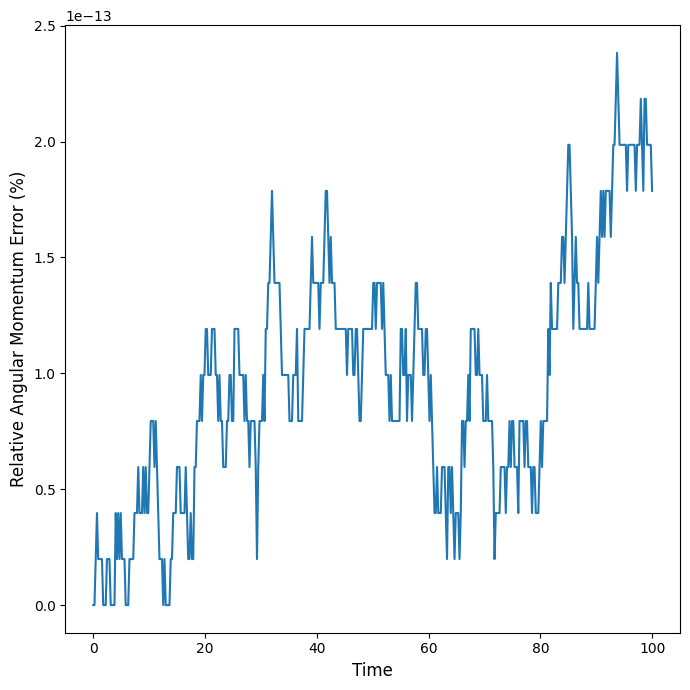

In [11]:
PlotOrbits(traj)
PlotEnergy(traj)
PlotAngularMomentum(traj)

#### LAGRANGE

In [12]:
# gravity
G = 1

m1 = 1
m2 = 1
m3 = 1

w = 0.75984

# position
r1 = np.array([0,1,0], dtype="float64")
r2 = np.array([- np.cos(np.pi / 6), - np.sin(np.pi / 6),0.0], dtype="float64")
r3 = np.array([np.cos(np.pi / 6), - np.sin(np.pi / 6),0.0], dtype="float64")

# velocity 
v1 = w * np.array([-1, 0, 0], dtype="float64")
v2 = w * np.array([np.sin(np.pi / 6),-np.cos(np.pi / 6),0], dtype="float64")
v3 = w* np.array([np.sin(np.pi / 6),np.cos(np.pi / 6),0], dtype="float64")

# create initial vectors
r0s = np.array([r1,r2,r3])
v0s = np.array([v1,v2,v3])
masses = np.array([m1, m2, m3])

In [13]:
traj = solver(100, 0.1, hlim, r0s, v0s, G, masses)

Time-limit reached


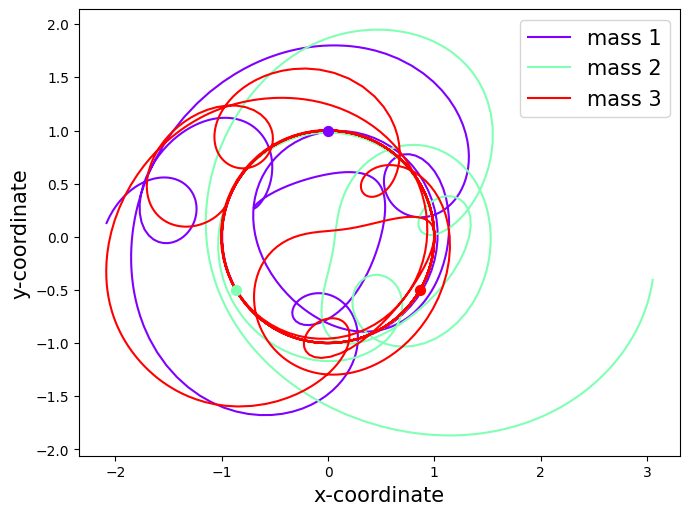

In [14]:
PlotOrbits(traj)